### Nhập dữ liệu ###


In [4]:


import pandas as pd
import gdown

# 1. Khai báo ID file
file_id = '1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS'
url = f'https://drive.google.com/uc?id={file_id}'

# 2. Tải file về bộ nhớ tạm của Colab
output = 'data.json'
gdown.download(url, output, quiet=False)

# 3. Đọc file bằng Pandas
# Lưu ý: Nếu file lớn, hãy kiểm tra xem có cần lines=True không
try:
    data = pd.read_json(output)
    print("Đọc thành công!")
    print(df.head())
except ValueError:
    # Thử lại với lines=True nếu file JSON dạng mỗi dòng 1 object
    data = pd.read_json(output, lines=True)
    print("Đọc thành công với lines=True!")
    print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS
To: /content/data.json
100%|██████████| 3.48M/3.48M [00:00<00:00, 197MB/s]

Đọc thành công!
          aspect    sentiment       date   source  \
0     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   
1  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
2     Chính sách     Tiêu cực 2025-08-01  FireAnt   
3  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
4     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   

                                       original_text date_str  
0  Lên TT coi bà NPH nói về V mà sợ, bà đó hay th...      NaN  
1  Trụ gãy sạch ma20 nhưng midcap lại kéo trần? N...      NaN  
2  CHÍNH THỨC MỸ ÁP THUẾ 20% VỚI VIỆT NAM HẾT ĐỒN...      NaN  
3  Nay cuối tuần - phiên đầu tháng sau kỳ bctc Q2...      NaN  
4  ❤️❤️ suy nghĩ nào vhm bán đất hì hục 6 tháng l...      NaN  


### Clean text ###

In [5]:
import re
import unicodedata

# 1. Dictionary xử lý Teencode mở rộng (bổ sung thêm)
teencode_dict = {
    "k": "không", "ko": "không", "kh": "không", "hok": "không", "kg": "không",
    "dc": "được", "dk": "được", "đc": "được",
    "ck": "chứng khoán", "cp": "cổ phiếu", "ckb": "chứng khoán",
    "mn": "mọi người", "ae": "anh em", "mn": "mọi người",
    "ad": "admin",
    "ntn": "như thế nào", "kq": "kết quả",
    "tks": "cảm ơn", "thanks": "cảm ơn", "thank": "cảm ơn",
    "vni": "vnindex", "vni": "vnindex",
    "vs": "với", "v": "với",
    "cx": "cũng", "cũg": "cũng",
}

# 2. Từ phủ định trong tiếng Việt (để nối với từ đi sau)
NEGATION_WORDS = {
    "không", "ko", "kh", "hok", "kg", "chẳng", "chả", "chưa",
    "không phải", "không phải là", "đâu có", "đâu phải"
}

# 3. Emoji mapping (chuyển emoji thành từ có nghĩa)
emoji_dict = {
    '😀': ' vui ', '😃': ' vui ', '😄': ' vui ', '😁': ' vui ', '😊': ' vui ',
    '😍': ' thích ', '😎': ' tuyệt ', '😇': ' tốt ',
    '😢': ' buồn ', '😭': ' buồn ', '😔': ' buồn ', '😞': ' buồn ',
    '😡': ' giận ', '😠': ' giận ', '😤': ' tức ',
    '👍': ' tốt ', '👎': ' tệ ', '❤': ' thích ', '💔': ' buồn ',
    '🔥': ' hot ', '💯': ' tốt ', '🎉': ' vui ', '🎊': ' vui ',
}

def handle_negation(text):
    """
    Xử lý từ phủ định: Nối các từ phủ định với từ đi sau để giữ ngữ nghĩa
    VD: "không thích" -> "không_thích", "chẳng đẹp" -> "chẳng_đẹp"
    """
    words = text.split()
    result = []
    i = 0
    while i < len(words):
        # Kiểm tra nếu từ hiện tại là từ phủ định
        if words[i] in NEGATION_WORDS:
            # Nối với 1-2 từ tiếp theo (thường là động từ/tính từ)
            negation_phrase = words[i]
            j = i + 1
            # Nối tối đa 2 từ tiếp theo
            while j < len(words) and j < i + 3:
                if words[j] not in NEGATION_WORDS:  # Tránh lặp phủ định
                    negation_phrase += "_" + words[j]
                    j += 1
                else:
                    break
            result.append(negation_phrase)
            i = j
        else:
            result.append(words[i])
            i += 1
    return " ".join(result)

def clean_text_optimized(text):
    """
    Hàm làm sạch văn bản tiếng Việt với các cải tiến:
    1. Xử lý Emoji (chuyển thành từ có nghĩa)
    2. Xử lý Teencode
    3. Xử lý từ phủ định (Negation Handling) - QUAN TRỌNG
    4. Chuẩn hóa kỹ thuật
    """
    if not isinstance(text, str):
        return ""

    # --- BƯỚC 1: Sơ chế cơ bản ---
    text = text.lower().strip()

    # Loại bỏ URL/Link
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)  # Loại bỏ HTML tags

    # --- BƯỚC 2: Xử lý Emoji (chuyển thành từ có nghĩa trước khi loại bỏ) ---
    for emoji, replacement in emoji_dict.items():
        text = text.replace(emoji, replacement)

    # Loại bỏ emoji và ký tự đặc biệt còn lại
    text = re.sub(r'[^\w\s,.!?àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]', ' ', text)

    # --- BƯỚC 3: Xử lý Teencode ---
    words = text.split()
    words = [teencode_dict.get(word, word) for word in words]
    text = " ".join(words)

    # --- BƯỚC 4: XỬ LÝ TỪ PHỦ ĐỊNH (NEGATION HANDLING) - QUAN TRỌNG ---
    # Nối các từ phủ định với từ đi sau để giữ ngữ nghĩa
    text = handle_negation(text)

    # --- BƯỚC 5: Chuẩn hóa kỹ thuật ---
    # Xóa các ký tự kéo dài: "quááá" -> "quá"
    text = re.sub(r'([a-zà-ỹ])\1{2,}', r'\1', text)

    # Chuẩn hóa khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()

    return text
data['cleaned_text'] = data['original_text'].apply(clean_text_optimized)
data.head(10)

,aspect,sentiment,date,source,original_text,date_str,cleaned_text
0,Kinh doanh,Tiêu cực,2025-08-01,FireAnt,"Lên TT coi bà NPH nói về V mà sợ, bà đó hay th...",NaN,"lên tt coi bà nph nói về với mà sợ, bà đó hay ..."
1,Diễn biến giá,Bình thường,2025-08-01,FireAnt,Trụ gãy sạch ma20 nhưng midcap lại kéo trần? N...,NaN,trụ gãy sạch ma20 nhưng midcap lại kéo trần? n...
2,Chính sách,Tiêu cực,2025-08-01,FireAnt,CHÍNH THỨC MỸ ÁP THUẾ 20% VỚI VIỆT NAM HẾT ĐỒN...,NaN,chính thức mỹ áp thuế 20 với việt nam hết đồn ...
3,Diễn biến giá,Bình thường,2025-08-01,FireAnt,Nay cuối tuần - phiên đầu tháng sau kỳ bctc Q2...,NaN,nay cuối tuần phiên đầu tháng sau kỳ bctc q2.....
4,Kinh doanh,Tiêu cực,2025-08-01,FireAnt,❤️❤️ suy nghĩ nào vhm bán đất hì hục 6 tháng l...,NaN,thích thích suy nghĩ nào vhm bán đất hì hục 6 ...
5,Chính sách,Bình thường,2025-08-01,FireAnt,;;;;;;;; Chứng khoán Ngày thuế quan có hiệu lự...,NaN,chứng khoán ngày thuế quan có hiệu lực chính t...
6,Chiến lược & Ban lãnh đạo,Tiêu cực,2025-08-01,FireAnt,"Ai yêu nước thì dập VIC chết mẹ nó đi, bắt tay...",NaN,"ai yêu nước thì dập vic chết mẹ nó đi, bắt tay..."
7,Diễn biến giá,Bình thường,2025-08-01,FireAnt,1800 VHM 120. VIC 150,NaN,1800 vhm 120. vic 150
8,Diễn biến giá,Bình thường,2025-08-01,FireAnt,🔥 31/7 – Giằng co vùng 1.500: Điều chỉnh hay t...,NaN,hot 31 7 giằng co vùng 1.500 điều chỉnh hay tí...
9,Chính sách,Tiêu cực,2025-08-01,FireAnt,Vn xuất qua mỹ bị đánh thuế 20% vậy xe điện vi...,NaN,vn xuất qua mỹ bị đánh thuế 20 vậy xe điện vin...


In [6]:
from sklearn.model_selection import train_test_split

# Đảm bảo biến 'data' (hoặc 'df') đã là dataframe cuối cùng cần dùng
if 'cleaned_text' not in data.columns:
    raise ValueError("❌ LỖI: Bạn chưa chạy bước Preprocessing (làm sạch dữ liệu). Hãy quay lại bước trên!")
else:
    # Chuẩn hóa và tách nhãn/dữ liệu
    X = data['cleaned_text'].copy()
    y = data['sentiment'].copy()

    # Chia train/test hợp lý
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,  # Đảm bảo phân bố nhãn đều ở train/test
        random_state=42
    )

    print("✅ Đã chia dữ liệu thành công!")
    print(f"- Tập Train (X_train): {X_train.shape[0]} dòng")
    print(f"- Tập Test (X_test):  {X_test.shape[0]} dòng")

✅ Đã chia dữ liệu thành công!
- Tập Train (X_train): 6559 dòng
- Tập Test (X_test):  1640 dòng


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# CẢI THIỆN TF-IDF VECTORIZER VỚI N-GRAMS VÀ THAM SỐ TỐI ƯU
tfidf = TfidfVectorizer(
    # 1. Bắt từ tiếng Việt chính xác (bao gồm cả từ có dấu gạch dưới từ negation handling)
    token_pattern=r"(?u)\b[\wÀ-ỹ_]+\b",

    # 2. N-gram MỞ RỘNG: (1, 3) để bắt được cụm từ dài hơn
    # Bigram: "bắt_đáy", "bán_tháo", "không_thích"
    # Trigram: "rất_tệ_lắm", "bình_thường_thôi"
    ngram_range=(1, 3),  # Tăng từ (1,2) lên (1,3) để bắt được ngữ cảnh tốt hơn

    # 3. Lọc rác tinh vi hơn
    min_df=2,       # Từ phải xuất hiện ít nhất 2 lần (giảm từ 3 để giữ nhiều feature hơn)
    max_df=0.90,    # Loại bỏ từ xuất hiện > 90% (tăng từ 0.85 để giữ thêm từ quan trọng)

    # 4. Tăng số lượng features để mô hình học được nhiều n-gram hơn
    max_features=8000,  # Tăng từ 6000 lên 8000 để chứa nhiều n-gram hơn

    # 5. Sublinear TF scaling (log scaling) để giảm tác động của từ xuất hiện quá nhiều
    sublinear_tf=True,

    # 6. Sử dụng IDF (Inverse Document Frequency) để trọng số hóa từ hiếm
    use_idf=True,
    smooth_idf=True  # Tránh chia cho 0
)

print("Đang tạo ma trận TF-IDF cho 8000 dòng dữ liệu...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print(f"✅ Hoàn tất! Kích thước tập Train: {X_train_tfidf.shape}")
print(f"✅ Kích thước tập Test: {X_test_tfidf.shape}")

Đang tạo ma trận TF-IDF cho 8000 dòng dữ liệu...
✅ Hoàn tất! Kích thước tập Train: (6559, 8000)
✅ Kích thước tập Test: (1640, 8000)


🔹 Training model: Naive Bayes (MultinomialNB)
✅ Accuracy: 0.6006

📊 Classification report:
              precision    recall  f1-score   support

 Bình thường     0.5714    0.5311    0.5505       595
    Tiêu cực     0.5757    0.7042    0.6335       524
    Tích cực     0.6726    0.5758    0.6205       521

    accuracy                         0.6006      1640
   macro avg     0.6066    0.6037    0.6015      1640
weighted avg     0.6049    0.6006    0.5993      1640



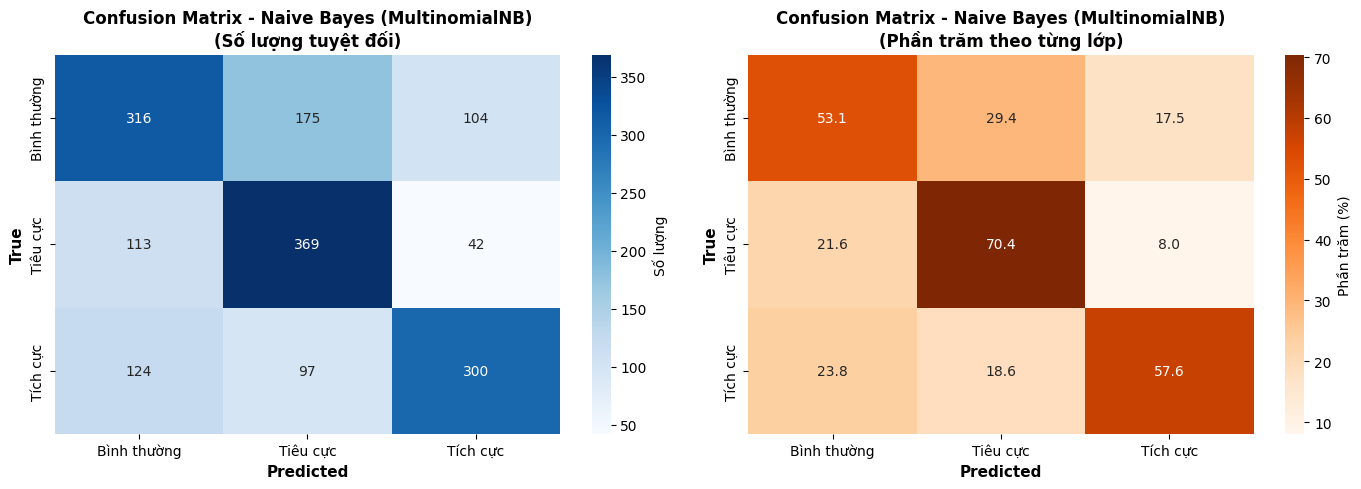


🔍 PHÂN TÍCH LỖI CHI TIẾT:
--------------------------------------------------------------------------------
❌ Bình thường → Tiêu cực: 175 mẫu (29.4%)
❌ Bình thường → Tích cực: 104 mẫu (17.5%)
❌ Tiêu cực → Bình thường: 113 mẫu (21.6%)
❌ Tiêu cực → Tích cực: 42 mẫu (8.0%)
❌ Tích cực → Bình thường: 124 mẫu (23.8%)
❌ Tích cực → Tiêu cực: 97 mẫu (18.6%)
🔹 Training model: Logistic Regression
✅ Accuracy: 0.6262

📊 Classification report:
              precision    recall  f1-score   support

 Bình thường     0.5723    0.6050    0.5882       595
    Tiêu cực     0.6479    0.6355    0.6416       524
    Tích cực     0.6720    0.6411    0.6562       521

    accuracy                         0.6262      1640
   macro avg     0.6307    0.6272    0.6287      1640
weighted avg     0.6281    0.6262    0.6269      1640



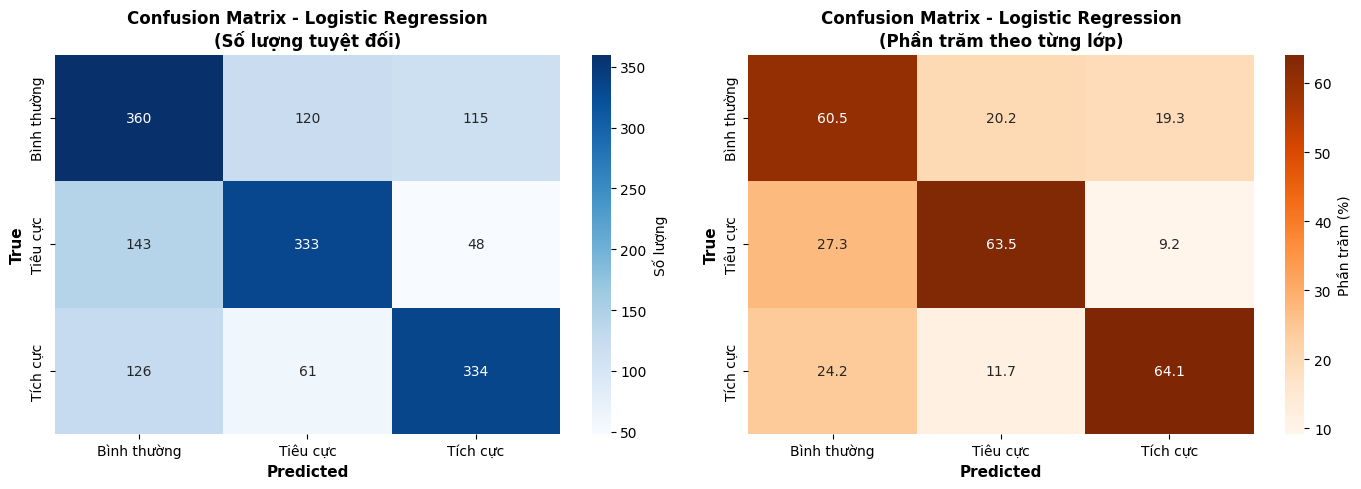


🔍 PHÂN TÍCH LỖI CHI TIẾT:
--------------------------------------------------------------------------------
❌ Bình thường → Tiêu cực: 120 mẫu (20.2%)
❌ Bình thường → Tích cực: 115 mẫu (19.3%)
❌ Tiêu cực → Bình thường: 143 mẫu (27.3%)
❌ Tiêu cực → Tích cực: 48 mẫu (9.2%)
❌ Tích cực → Bình thường: 126 mẫu (24.2%)
❌ Tích cực → Tiêu cực: 61 mẫu (11.7%)
🔹 Training model: Linear SVM
✅ Accuracy: 0.6067

📊 Classification report:
              precision    recall  f1-score   support

 Bình thường     0.5604    0.5613    0.5609       595
    Tiêu cực     0.6214    0.6202    0.6208       524
    Tích cực     0.6449    0.6449    0.6449       521

    accuracy                         0.6067      1640
   macro avg     0.6089    0.6088    0.6089      1640
weighted avg     0.6067    0.6067    0.6067      1640



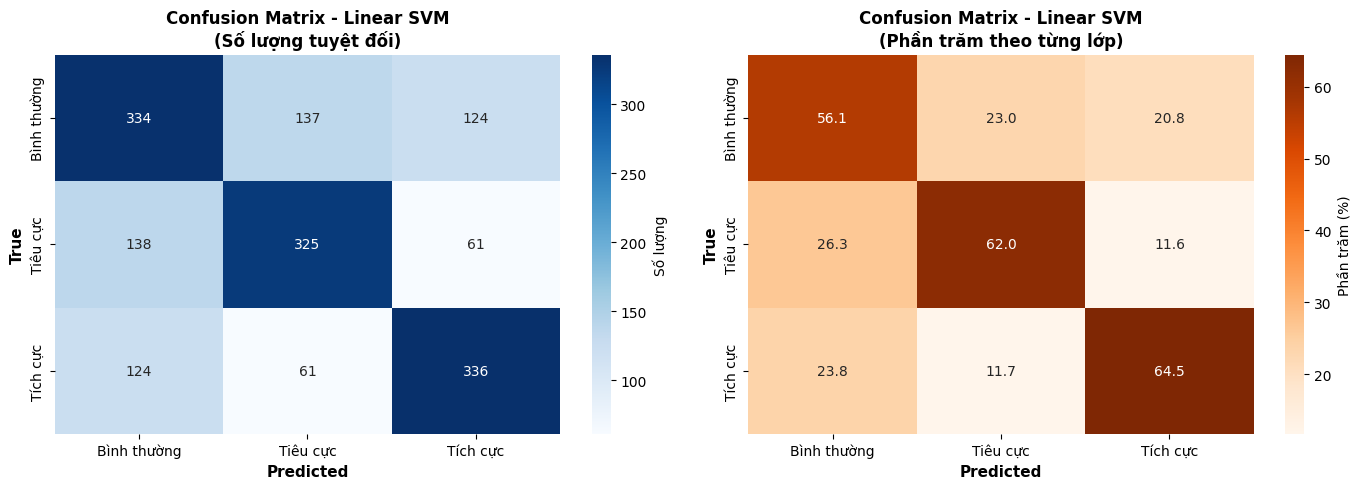


🔍 PHÂN TÍCH LỖI CHI TIẾT:
--------------------------------------------------------------------------------
❌ Bình thường → Tiêu cực: 137 mẫu (23.0%)
❌ Bình thường → Tích cực: 124 mẫu (20.8%)
❌ Tiêu cực → Bình thường: 138 mẫu (26.3%)
❌ Tiêu cực → Tích cực: 61 mẫu (11.6%)
❌ Tích cực → Bình thường: 124 mẫu (23.8%)
❌ Tích cực → Tiêu cực: 61 mẫu (11.7%)
🔹 Training model: Random Forest
✅ Accuracy: 0.6000

📊 Classification report:
              precision    recall  f1-score   support

 Bình thường     0.5554    0.6235    0.5875       595
    Tiêu cực     0.5996    0.5973    0.5985       524
    Tích cực     0.6667    0.5758    0.6179       521

    accuracy                         0.6000      1640
   macro avg     0.6072    0.5989    0.6013      1640
weighted avg     0.6049    0.6000    0.6007      1640



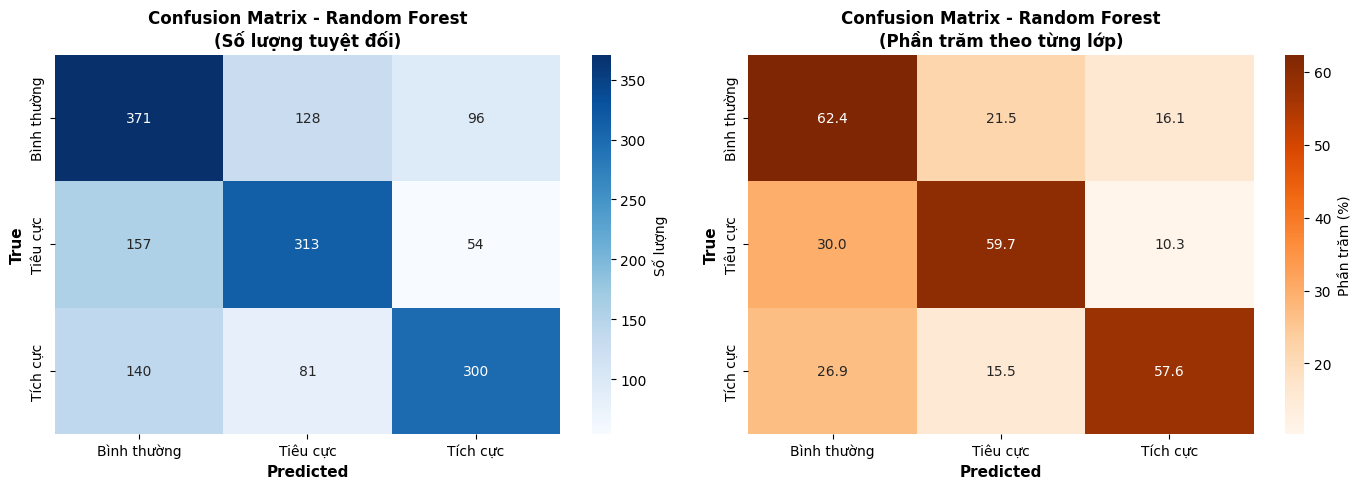


🔍 PHÂN TÍCH LỖI CHI TIẾT:
--------------------------------------------------------------------------------
❌ Bình thường → Tiêu cực: 128 mẫu (21.5%)
❌ Bình thường → Tích cực: 96 mẫu (16.1%)
❌ Tiêu cực → Bình thường: 157 mẫu (30.0%)
❌ Tiêu cực → Tích cực: 54 mẫu (10.3%)
❌ Tích cực → Bình thường: 140 mẫu (26.9%)
❌ Tích cực → Tiêu cực: 81 mẫu (15.5%)

📌 So sánh Accuracy các mô hình:
                         model  accuracy
1          Logistic Regression  0.626220
2                   Linear SVM  0.606707
0  Naive Bayes (MultinomialNB)  0.600610
3                Random Forest  0.600000


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Khai báo các mô hình muốn so sánh
models = {
    "Naive Bayes (MultinomialNB)": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )
}

results = []

for name, model in models.items():
    print("=" * 80)
    print(f"🔹 Training model: {name}")

    # 2. Train
    model.fit(X_train_tfidf, y_train)

    # 3. Dự đoán
    y_pred = model.predict(X_test_tfidf)

    # 4. Đánh giá
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}\n")

    print("📊 Classification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Lưu kết quả để so sánh sau
    results.append({
        "model": name,
        "accuracy": acc
    })

    # 5. Vẽ confusion matrix với phân tích chi tiết
    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(list(set(y_test)))

    # Tính toán phần trăm thay vì chỉ số tuyệt đối
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix số tuyệt đối
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                ax=axes[0], cbar_kws={'label': 'Số lượng'})
    axes[0].set_xlabel("Predicted", fontsize=11, fontweight='bold')
    axes[0].set_ylabel("True", fontsize=11, fontweight='bold')
    axes[0].set_title(f"Confusion Matrix - {name}\n(Số lượng tuyệt đối)", fontsize=12, fontweight='bold')

    # Confusion Matrix phần trăm
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Oranges',
                xticklabels=labels, yticklabels=labels,
                ax=axes[1], cbar_kws={'label': 'Phần trăm (%)'})
    axes[1].set_xlabel("Predicted", fontsize=11, fontweight='bold')
    axes[1].set_ylabel("True", fontsize=11, fontweight='bold')
    axes[1].set_title(f"Confusion Matrix - {name}\n(Phần trăm theo từng lớp)", fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 6. Phân tích lỗi chi tiết
    print("\n🔍 PHÂN TÍCH LỖI CHI TIẾT:")
    print("-" * 80)
    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            if i != j and cm[i, j] > 0:  # Chỉ hiển thị lỗi
                percentage = (cm[i, j] / cm[i].sum()) * 100
                print(f"❌ {true_label} → {pred_label}: {cm[i, j]} mẫu ({percentage:.1f}%)")

# 6. Bảng so sánh accuracy giữa các mô hình
results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
print("\n📌 So sánh Accuracy các mô hình:")
print(results_df)


In [11]:

import pickle

print("🔄 Đang train model...")
best_model = LogisticRegression(max_iter=500, n_jobs=-1)
best_model.fit(X_train_tfidf, y_train)
print("✅ Train xong!")


# --- LƯU MODEL VÀO FILE PKL ---
model_filename = 'best_LR_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"💾 Đã lưu model vào file: {model_filename}")

# Lưu cả TfidfVectorizer để dùng sau này:
vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(tfidf, file)
print(f"💾 Đã lưu vectorizer vào file: {vectorizer_filename}")


🔄 Đang train model...
✅ Train xong!
💾 Đã lưu model vào file: best_LR_model.pkl
💾 Đã lưu vectorizer vào file: tfidf_vectorizer.pkl


In [13]:
import pickle

# --- LOAD MODEL ---
with open('best_LR_model.pkl', 'rb') as file: # Đã chỉnh sửa tên file model để phù hợp với tên đã lưu trước đó
    loaded_model = pickle.load(file)

# --- LOAD VECTORIZER ---
with open('tfidf_vectorizer.pkl', 'rb') as file:
    loaded_vectorizer = pickle.load(file)

# --- DỰ ĐOÁN ---
# Trên tập test
y_pred = loaded_model.predict(X_test_tfidf)

# Hoặc trên text mới
new_texts = [
    "Cổ phiếu này tăng mạnh",
    "Giá đang giảm sâu",
    "Thị trường có vẻ tích cực trở lại",
    "Đà giảm vẫn chưa dừng lại",
    "Không có nhiều thay đổi hôm nay",
    "Nhiều tin tức tốt đang đến",
    "Công ty làm ăn thua lỗ"
]
new_texts_tfidf = loaded_vectorizer.transform(new_texts)
predictions = loaded_model.predict(new_texts_tfidf)
print(f"🔮 Dự đoán: {predictions}")

🔮 Dự đoán: ['Tích cực' 'Tiêu cực' 'Bình thường' 'Bình thường' 'Bình thường'
 'Tích cực' 'Tiêu cực']
